In [27]:
# automatically reload imported modules
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import sys
import matplotlib
from matplotlib import pyplot as plt
import pylab as pl

from filters import GrayscaleNormalizer

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

FOLDER_PATH = '/Users/delinwang/Desktop/Concrete Crack Images for Classification.rar Folder/'
FOLDER_PATH = 'C:/Users/Dominic/Desktop/Concrete Crack Images for Classification/'

SUTD_PATH = 'C:/Users/Dominic/Desktop/SUTD Cracks/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
imgs = []
normalize_grayscale = GrayscaleNormalizer()

img = cv2.imread(FOLDER_PATH + 'Positive/00001.jpg', 0).astype(np.float32)
imgs.append( normalize_grayscale(img) )

img = cv2.imread(SUTD_PATH + 'Positive/00001.jpg', 0).astype(np.float32)
imgs.append( normalize_grayscale(img) )

In [5]:
from filters import *
import preprocessing.shadow_reduction

filters = {}

grayscale       = GrayscaleNormalizer()
bilateral_canny = BilateralCanny()

filters['no filter']       = lambda x : x
filters['grayscale']       = grayscale.__call__
filters['canny']           = bilateral_canny.canny_img
filters['bilateral canny'] = bilateral_canny.bilateral_canny_img
filters['tophat']          = tophat
filters['canny gradient']  = canny_gradient
filters['otsu']            = otsu
filters['blackhat']        = blackhat
filters['gradient']        = gradient
filters['gradient2']       = gradient2
filters['gradient3']       = gradient3

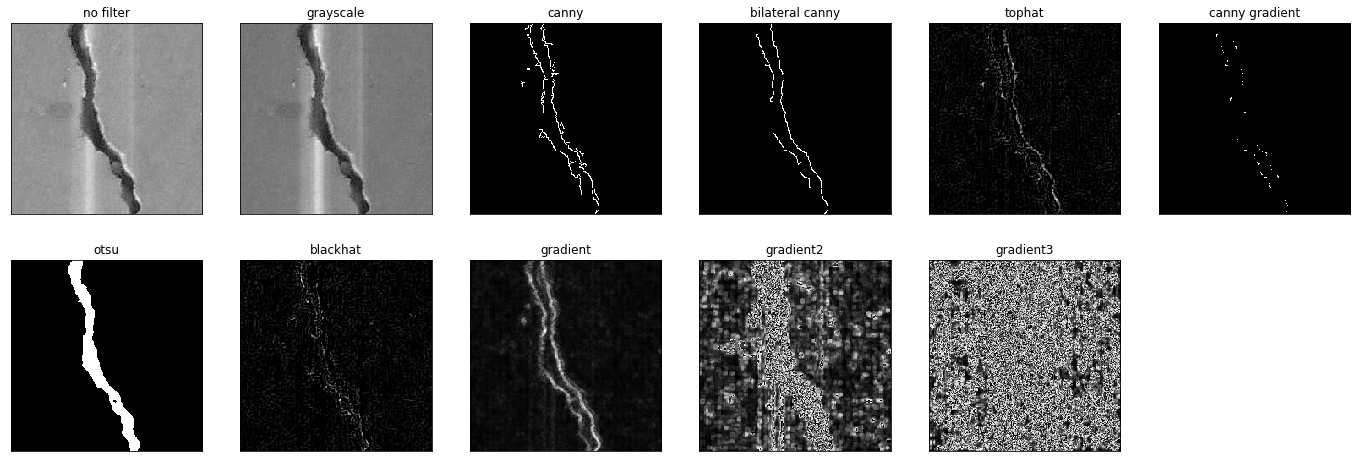

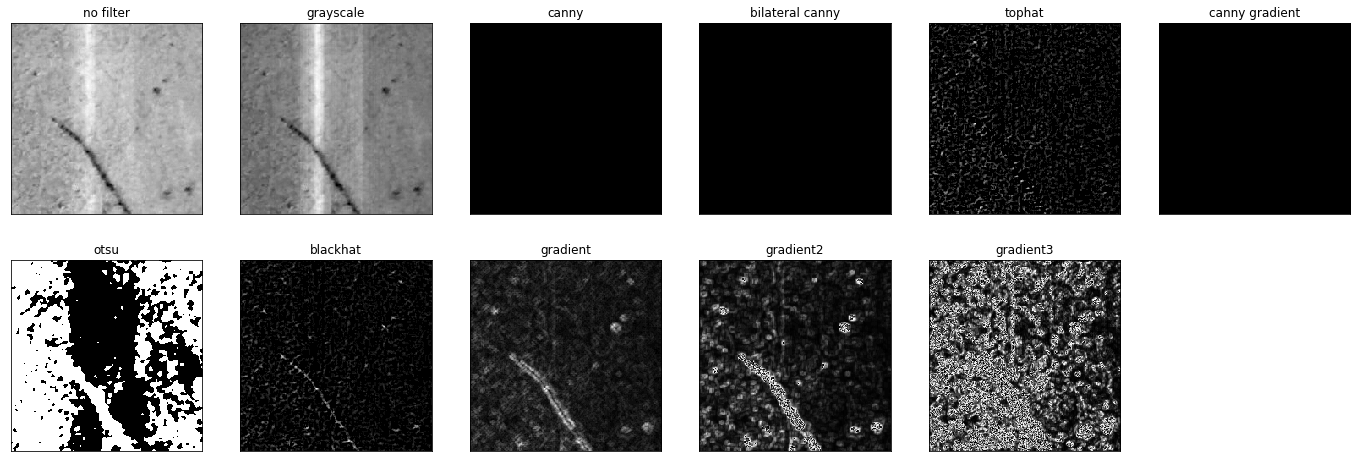

In [29]:
for img in imgs:
    plt.figure(figsize=(24,8))

    i = 1
    for filter_name, filter_func in filters.items():
        plt.subplot(2, 6, i),plt.imshow(filter_func(img), cmap='gray')
        plt.title(filter_name),plt.xticks([]),plt.yticks([])

        i += 1

    plt.show()